[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sagar87/scCCA/blob/main/docs/notebooks/kang.ipynb)

*In order to run this notebook in Google Colab run the following cells. For best performance make sure that you run the notebook on a GPU instance, i.e. choose from the menu bar Runtime > Change Runtime > Hardware accelerator > GPU.*

In [3]:
# Install scCCA + depenencies
!pip install --quiet scCCA scikit-misc

In [2]:
# Download the Kang et. al. dataset
!wget https://www.huber.embl.de/users/harald/sc/kang.h5ad /content/kang.h5ad

# Analysing interferon-$\beta$ stimulated PBMCs using scPCA

In this notebook, we analyse the dataset from Kang et. al. in which the authors stimulated PBMCs with Interferon-$\beta$. We load the dataset using `scanpy`.

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scCCA as scc
import seaborn as sns

In [4]:
torch.manual_seed(16846846)

In [5]:
adata = sc.read_h5ad('/content/kang.h5ad')

The canonical approach to analyse single cell datasets involves to select highly variable genes followed by a logCPM transformation of the count data prior to PCA. Note that we save the original count data in the layers slot of the `adata` object, because `scPCA` operates on directly count data.

In [6]:
adata.layers["counts"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True,
    layer="counts"
)

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [8]:
sc.tl.pca(adata, n_comps=15)

We now generate a UMAP from PCA cell embeddings to obtain an overview of the dataset. The `scc.tl.umap` function first creates a nearest neighborhood graph and subsequently calculates UMAP coordinates.

In [9]:
scc.tl.umap(adata, 'X_pca')

Plotting the UMAPs reveals that although the PCA embeddings preserved the cellular identity within both conditions, they fail to align those properly within within UMAP space. This results in a separation of control and stimulated cells along the second UMAP axis (`X_pca_umap2`).

/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


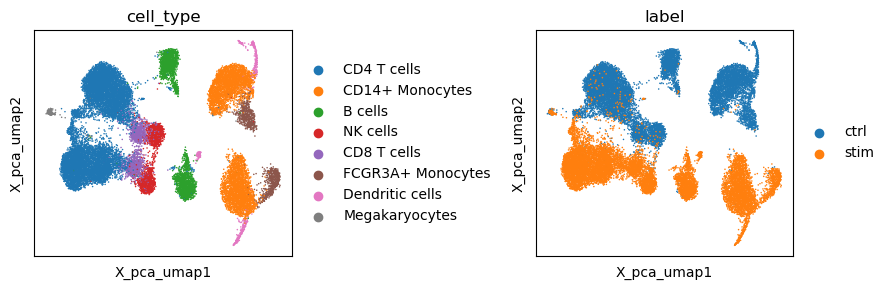

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_pca_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_pca_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

To understand why, we proceed by investigating the PCA factors. In particular, we plot the factor weights of the first few principal components using the `scc.pl.factor_embedding` function on top of the UMAP coordinates. Visual inspection indicates that the first factor (`Factor 0`) is likely to represent an axis of variation that delineates CD14+/FCGR3A+ monocytes and dendritic cells from all other cell types within the dataset. The second principal component (`Factor 1`) however seems to separate the condition, i.e. whether the cell origins from the control or stimulated experiment.

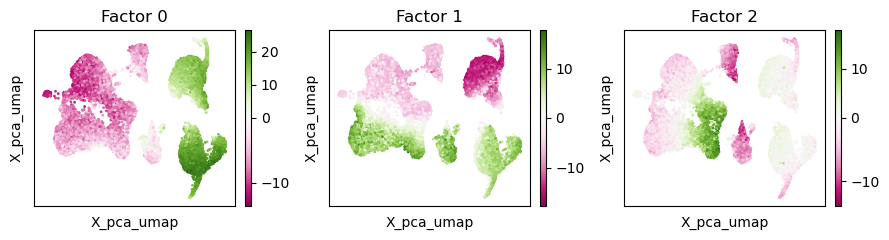

In [11]:
scc.pl.factor_embedding(adata, 'pca', 'X_pca_umap', factor=[0, 1, 2], width=3, height=2.5)
plt.tight_layout()

While the separation of cells across conditions is expected, it poses potential problems for further downstream analyses. Clustering by cell type, for example, is difficult due to the presence of `Factor 1` which separates same cell types by condition. For this reason, it is desirebable to account for the experimental condition while performing the dimensionality reduction. In `scPCA`, we inform the model about the experimental condition of each cell by employing design matrices. To understand how, we consider in this tutorial the usage of different design matrices, and explore the consequences on the fitted latent representation.


## Recovering PCA, i.e. providing no information about the condition

To recover results that are similar to the PCA baseline, we provide two non-informative rank one matrices $D_1, B_1$ full of ones (depicted as black squares) as loading and intercept design matrix, respectively.

In [12]:
raw = "https://github.com/sagar87/scCCA/blob/7480621cbeb12cc296cf19ebbb75af61ceb515de/docs/notebooks/img/base_kang.png?raw=True"
Image(url=raw, width=150, height=100)

To instantiate such a model, we call the `scc.scPCA` constructor and provide the `anndata` object containing our data, the number of factors to extract and the R-style formulas for the loading (`design_formula`) and intercept (`batch_formula`) design matrices. The `scPCA` constructor returns a model object with a `.fit()` method which by default trains the model aggressively with a learning rate of `lr=0.01` for 5000 training steps. Further training steps at a lower learning are often beneficial and may be added by calling the `.fit` method for a second time.

In [13]:
m0 = scc.scPCA(adata, 15, layers_key='counts', design_formula='1', batch_formula='1')

In [14]:
m0.fit()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/voehring/voehring/opt/scCCA/scCCA/model.py:206: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  α_rna = deterministic("α_rna", (1 / α_rna_inv).T)
Epoch: 4990 | lr: 1.00E-02 | ELBO: 7847740 | Δ_10: -20655.50 | Best: 7533944: 100%|██████████| 5000/5000 [03:22<00:00, 24.65it/s]  


In [15]:
m0.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7707766 | Δ_10: -99021.50 | Best: 7504334: 100%|██████████| 2000/2000 [01:22<00:00, 24.32it/s] 


To obtain the results, we invoke the `.mean_to_anndata` function which computes the posterior mean of fitted parameters and stores them to the `anndata` object. Specifying `model_key` adds a prefix to the added keys such that a single `anndata` object may contain the the fitted parameters of multiple models.

In [16]:
m0.mean_to_anndata(model_key='m0', num_split=64)

Predicting z for obs 24576-24672.: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


Most importantly the following variables are saved to the `anndata` object:

* Factor weights ($\mathbf{Z}$): `adata.obsm[f"X_{model_key}"]`
* Loading weights ($\mathbf{W}$): `adata.varm[f"{model_key}_W_rna"]`
* Intercept weights ($\mathbf{V}$): `adata.varm[f"{model_key}_V_rna"]`
* Predicted counts ($\boldsymbol{\mu}_{RNA}$): `adata.layers[f"{model_key}_μ_rna"]` 

In [17]:
adata 

AnnData object with n_obs × n_vars = 24673 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'multiplets', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'ident'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay', 'hvg', 'log1p', 'pca', 'X_pca', 'umap', 'cell_type_colors', 'label_colors', 'm0'
    obsm: 'X_pca', 'X_pca_umap', 'X_m0'
    varm: 'PCs', 'm0_W_rna', 'm0_V_rna', 'm0_α_rna', 'm0_σ_rna'
    layers: 'logcounts', 'counts', 'm0_μ_rna', 'm0_offset_rna'
    obsp: 'X_pca_distances', 'X_pca_connectivities'

We next compute a UMAP visualization on the embeddings of `m0`.

In [18]:
scc.tl.umap(adata, 'X_m0')

/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


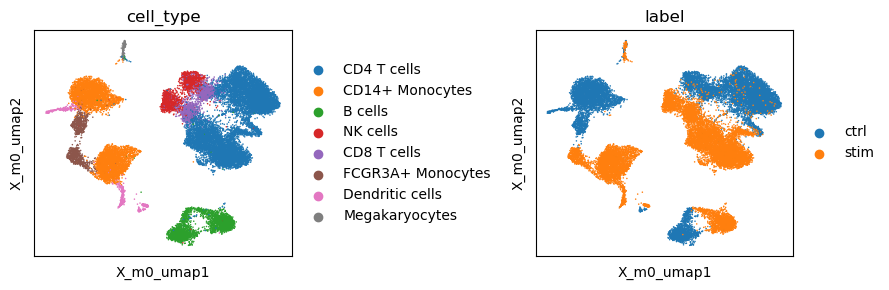

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m0_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m0_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

We find that the UMAP plot from `scPCA` cell embedding looks similar to the one which was based on PCA. We again look at the fitted factors$^1$ to obtain a better understanding about the captured "principal axis" of variation$^2$. Similar to PCA, we find a factor that seemingly delineates monocytes and dendritic cells from all other cells (`Factor 10`). The model also captured factors that explain differences between the control and stimulated condition (`Factor 0`, `Factor 1`).

----
$1$: Here we plot all facors because unlike in PCA, `scPCA` returns factors are not sorted by the amount of variance explained.<br>
$2$: Strictly speaking `scPCA` does not extract the principal axes of the data as it employs a non-isotropic noise model.

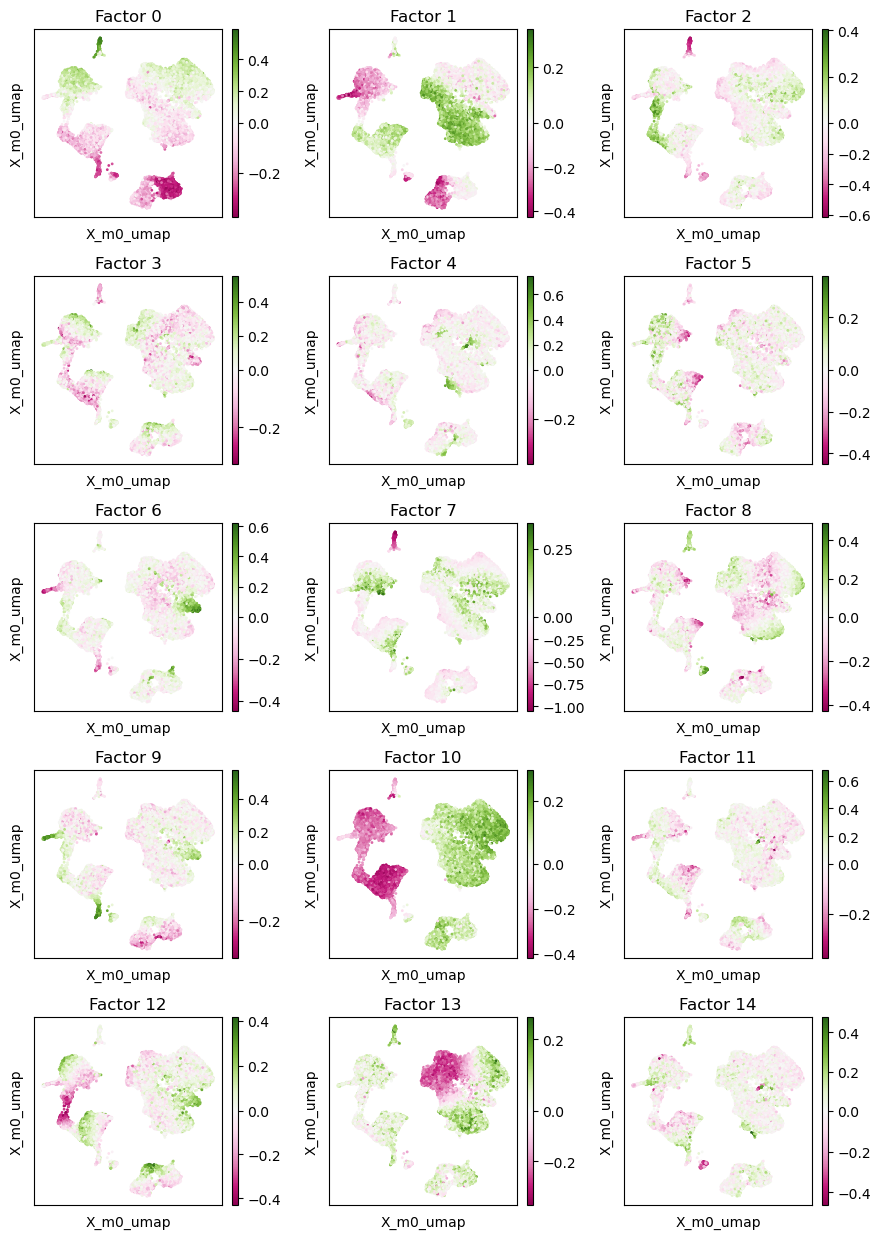

In [20]:
scc.pl.factor_embedding(adata, 'm0', 'X_m0_umap', width=3, height=2.5, ncols=3)
plt.tight_layout()

## Accounting for mean offsets using an intercept design matrix

As a first step we try to account for potential shifts in mean gene expression across conditions. Evidence for such shifts may be obtained by exploring how the number of total counts per cell differ between experimental condition.

In [21]:
adata.obs['label'] = pd.Categorical(adata.obs['label'], categories=['ctrl', 'stim'], ordered=True)
adata.obs['total_counts'] = np.asarray(adata.layers['counts'].sum(1)).reshape(-1)

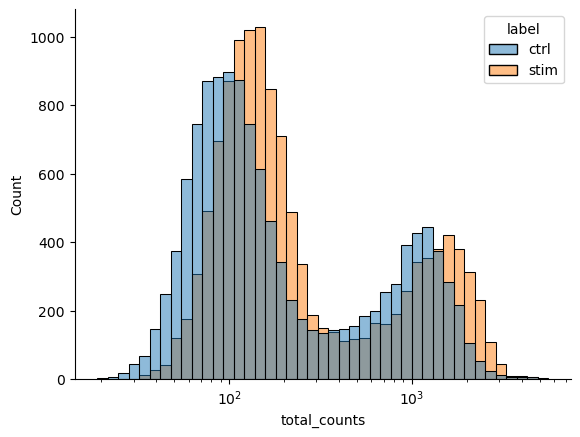

In [22]:
sns.histplot(x='total_counts', hue='label', data=adata.obs, log_scale=True)
sns.despine()

We find that cells from the stimulated condition tend to have a larger number of counts. To instruct the model to fit different means for both conditions, we consider the intercept design matrix $B_2$ which we may create by using the R-style formula `label-1` (see also https://patsy.readthedocs.io/en/latest/).

In [23]:
raw = "https://github.com/sagar87/scCCA/blob/7480621cbeb12cc296cf19ebbb75af61ceb515de/docs/notebooks/img/mean_kang.png?raw=True"
Image(url=raw, width=150, height=100)

In [24]:
m1 = scc.scPCA(adata, 15, layers_key='counts', design_formula='1', batch_formula='label-1')

In [25]:
m1.fit()

Epoch: 4990 | lr: 1.00E-02 | ELBO: 7740564 | Δ_10: -42451.50 | Best: 7638169: 100%|██████████| 5000/5000 [03:22<00:00, 24.68it/s]  


In [26]:
m1.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7816562 | Δ_10: 8327.50 | Best: 7556992: 100%|██████████| 2000/2000 [01:22<00:00, 24.33it/s]   


In [27]:
m1.mean_to_anndata(model_key='m1', num_split=64)

Predicting z for obs 24576-24672.: 100%|██████████| 13/13 [00:02<00:00,  4.46it/s]


As before we proceed by computing an UMAP to observe the information captured by the factors. 

In [28]:
scc.tl.umap(adata, 'X_m1')

/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


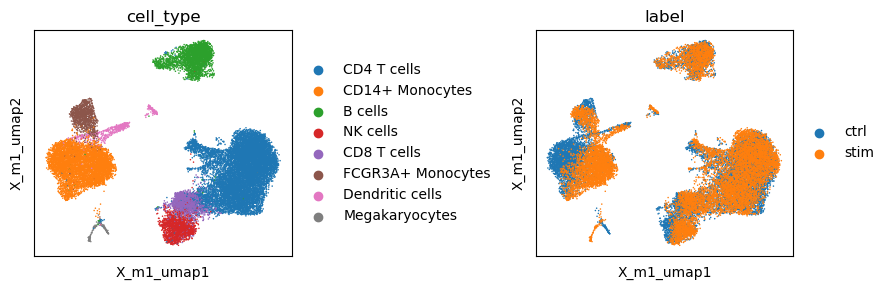

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m1_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m1_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

Strikingly, we observe that accounting for mean expression across coditions improves mixing across conditions substantially whilst preserving the identity of cells. Inspection of factors reveals the absence of a factor that clearly delineates the experimental condition.

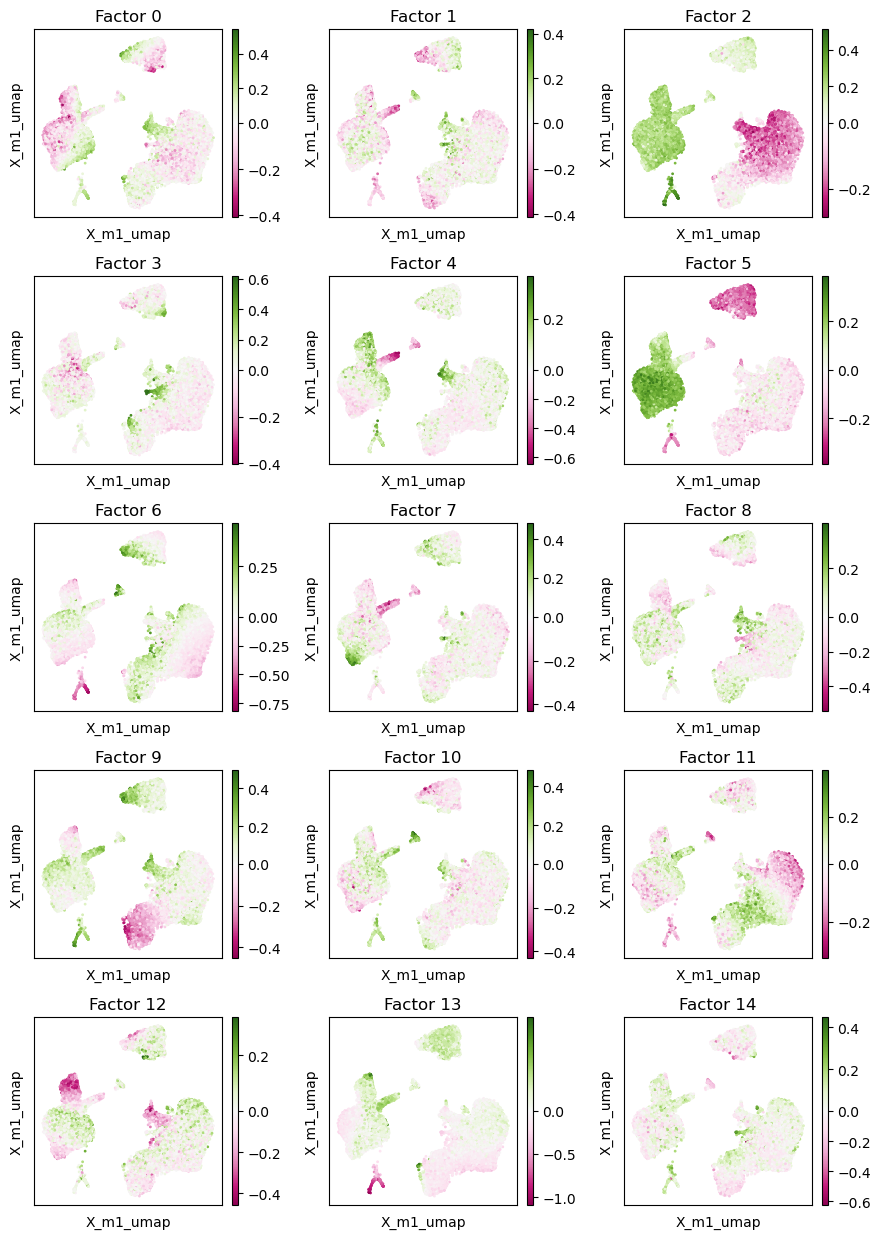

In [30]:
scc.pl.factor_embedding(adata, 'm1', 'X_m1_umap', width=3, height=2.5, ncols=3)
plt.tight_layout()

## Accounting for spectral shifts across conditions using a loading design matrix

Note that mixing of cells across conditions worked for all cell types except CD14+ monocytes which still clearly separate by condition. We next consider a model that specifies the design matrices $D_2$ and $B_2$.

In [31]:
raw = "https://github.com/sagar87/scCCA/blob/7480621cbeb12cc296cf19ebbb75af61ceb515de/docs/notebooks/img/full_kang.png?raw=True"
Image(url=raw, width=150, height=100)

Note that although both matrices have a column rank of two, $B_2$ exhibits a different structure from $D_2$. Particularly, $D_2$ contains a "intercept" column full of ones and an additional column in which cells from the control and stimulated conditions are marked with zeros and ones, respectively. This design matrix instructs the model to fit a set of basis vectors to the control condition and a separate set basis vectors to the stimulated condition. Importantly, the "intercept" column of $D_2$ introduces dependency between both bases, i.e. the bases for stimulated cells is expressed in terms of the basis vectors of the control.

In [32]:
m2 = scc.scPCA(adata, 15, layers_key='counts', design_formula='label', batch_formula='label-1')

In [33]:
m2.fit()

Epoch: 4990 | lr: 1.00E-02 | ELBO: 7706404 | Δ_10: 72009.00 | Best: 7586792: 100%|██████████| 5000/5000 [03:35<00:00, 23.15it/s]   


In [34]:
m2.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7801074 | Δ_10: -81267.00 | Best: 7532256: 100%|██████████| 2000/2000 [01:24<00:00, 23.70it/s] 


In [35]:
m2.mean_to_anndata(model_key='m2', num_split=64)

Predicting z for obs 24576-24672.: 100%|██████████| 13/13 [00:02<00:00,  4.69it/s]


Visual inspection of the UMAP suggests finally good mixing of the full dataset including CD14+ monocytes.

In [36]:
scc.tl.umap(adata, 'X_m2')

/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


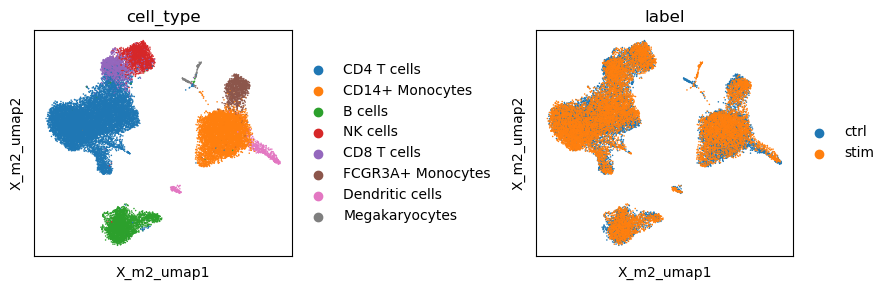

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m2_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m2_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

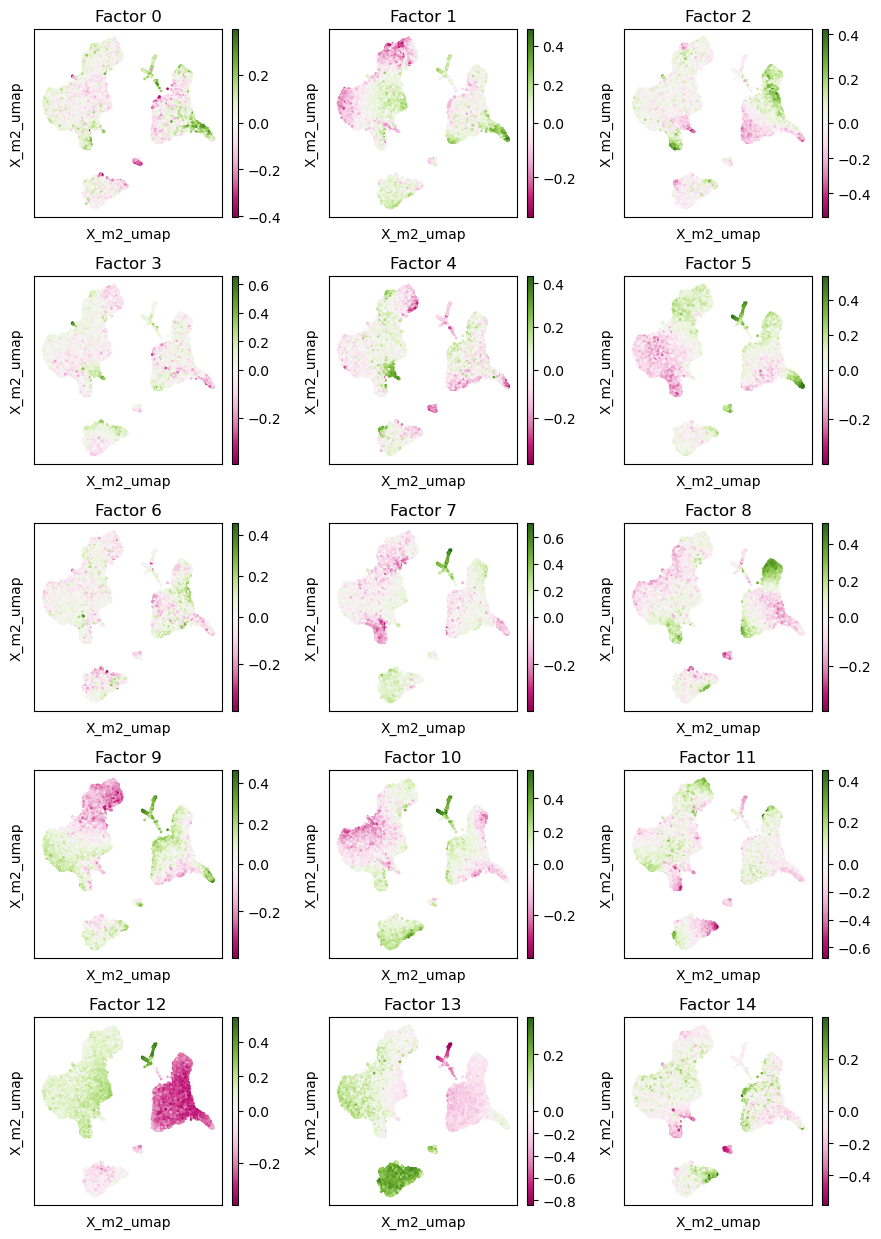

In [38]:
scc.pl.factor_embedding(adata, 'm2', 'X_m2_umap', width=3, height=2.5, ncols=3)
plt.tight_layout()

Inspecting the factors suggests that `Factor 8` constitutes particular large negative factor weights in CD14+ monocytes. To understand how the expression spectrum along this factor changed, we investigate loading weights of factor 8. These represent expression shifts relative to the mean expression in the corresponding condition condition. We may visualize these shifts using the `scc.pl.loadings_scatter` function which takes as an input the `anndata` object containing the model parameters and the factor and states (i.e. experimental condition) of interest. In the following plot, we show the top 20 upregulated genes in the interferon stimulated condition.

Text(30.972222222222214, 0.5, 'Loading weight')

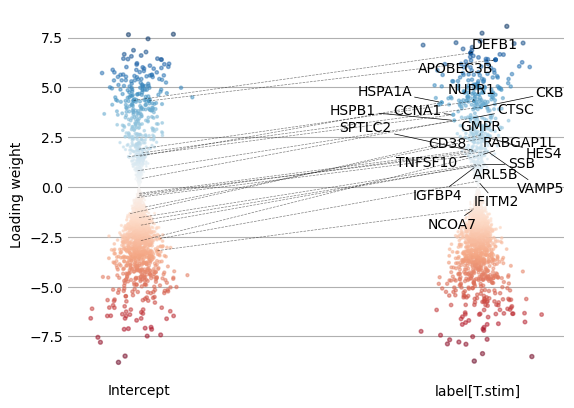

In [41]:
scc.pl.loadings_scatter(
    adata, 
    model_key='m2', # which model
    factor=12,  # factor
    states=['Intercept', 'label[T.stim]'], # state names are saved in adata.uns[f'{model_key}']['design']
    diff=['Intercept', 'label[T.stim]'], 
    sign=-1, # note that the factor weights of factor 8 are negative in monocytes (hence we need to multiply the factor by -1)
    highest=20, # top 20 upregulated genes
    lowest=0, # do not show downregulated genes
    alpha=.5, 
    show_labels=1, 
    vector='W_rna',
)
ax = plt.gca()
ax.set_ylabel('Loading weight')

Likewise we can investigate the downregulated genes by setting `lowest` to greater than 1.

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

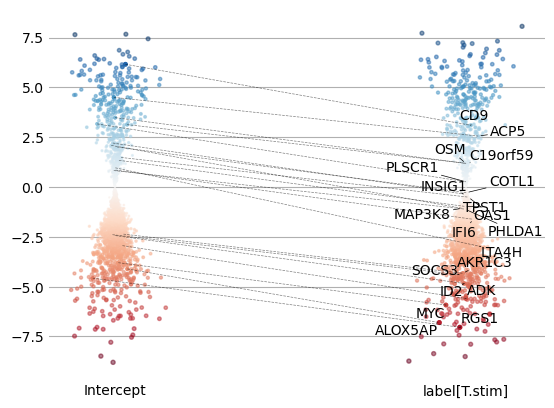

In [42]:
scc.pl.loadings_scatter(
    adata, 
    model_key='m2', 
    factor=12, 
    states=['Intercept', 'label[T.stim]'],  
    diff=['Intercept', 'label[T.stim]'], 
    lowest=20,
    highest=0,
    alpha=.5,
    sign=-1,
    show_labels=1, 
    vector='W_rna',
)